# ISM Reconstruction - STED

In ISM several slightly shifted images are recroded with a detector array and at the reconstruction stage they need to be fused together to generate a higher-SNR (and resolution) output image. 

In [25]:
%matplotlib inline

import os
from scipy.io import loadmat
import numpy as np
from supertomo.data.io import carma
from supertomo.ui.plots import image as implots
import supertomo.processing.image as imops

# Image
data_dir = "/Users/sami/Documents/Work/Data/2018_06_STED_ISM/Elena"
filename = "20170727_173938_425.mat"
full_path = os.path.join(data_dir, filename)

## Import Data

The image data is contained in a special Carma file format. Images are organized according to 1. the detector they were recorded with and 2. the laser gate number during which they were recorded. There's a special data structure *ArrayDetectorData* for holding such image collections in memory inside SuperTomo. Alternatively a HDF5 based *ImageData* structure can be used, in case the images are very large.

The Carma file 20170727_173938_425.mat contains images from 1 laser gates and 25 detector channels. 
The image size is (500, 500) and spacing is [0.02004008016032064, 0.02004008016032064]


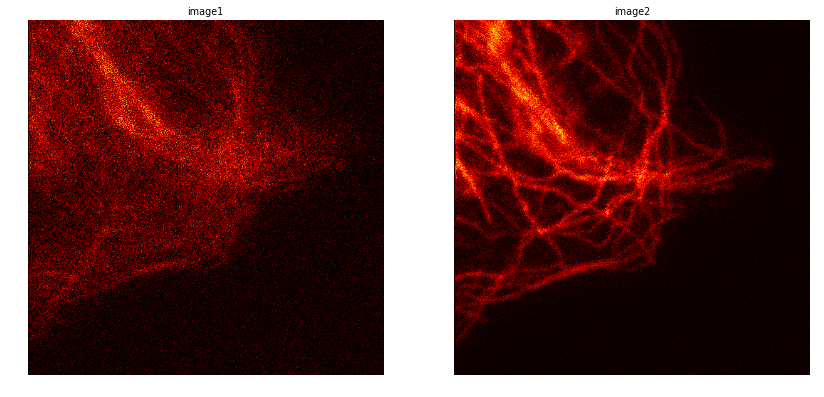

In [83]:
data = carma.read_carma_mat(full_path)

print "The Carma file {} contains images from {} laser gates and {} detector channels. ".format(
    filename, data.ngates, data.ndetectors)
print "The image size is {} and spacing is {}".format(data[0,0].shape, data[0,0].spacing)

#new_spacing = list (i/2 for i in data[0,0].spacing)
#for i in range(data.ndetectors):   
#    data[0,i] = imops.zoom_to_spacing(data[0,i], new_spacing, order=1)     

implots.display_2d_images(data[0,20], data[0,12])

## Evaluate data quality

The template image shown holds information of the effective system PSF and also it can be used to evaluate how well the detector was aligned during data acquisition.

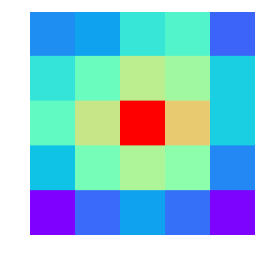

In [27]:
from supertomo.processing.ism import helpers as ismhelpers

template = ismhelpers.make_template_image(data)

implots.display_2d_image(template[0])

## Registration

In order to perform the reassignment the images have to be registered (aligned into a single coordinate grid). For this I use a iterative image registration algorithm that I originally developed for a CLEM application. Let's first try this out with a single image pair. The image number 12 is the central pixel, whereas 8 is one of the corner pixels in the 3x3 central area.

Setting up registration job
Starting registration
Final metric value: -0.71286382085
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Gradient magnitude tolerance met after 68 iterations. Gradient magnitude (9.70267e-05) is less than gradient magnitude tolerance (0.0001).


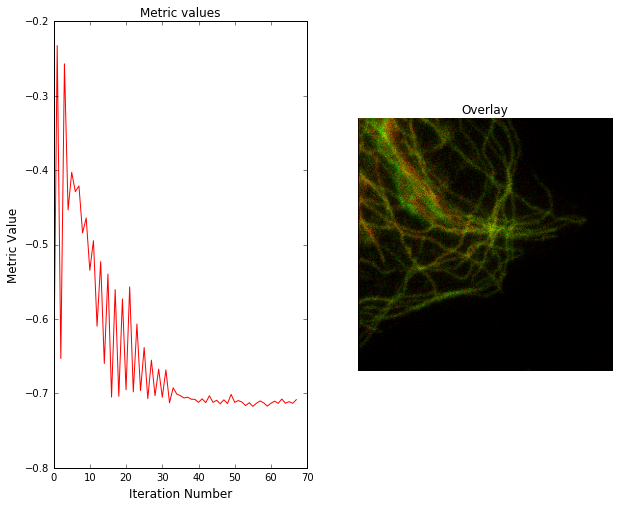

In [28]:
import supertomo.ui.supertomo_options as options
from supertomo.processing.registration import registration
from supertomo.processing import itk

fixed_image = itk.convert_to_itk_image(data[0, 12])
moving_image = itk.convert_to_itk_image(data[0, 13])


args = ("{} --sampling-percentage=1 --reg-relax-factor=.9 --learning-rate=1 --min-step=0.0005 "         
        "--reg-max-iterations=300 --reg-method=correlation --reg-translate-only " 
        "--reg-enable-observers".format(full_path)).split()

options = options.get_ism_script_options(args)

transform = registration.itk_registration_rigid_2d(fixed_image, moving_image, options)

In [29]:
print transform


itk::simple::Transform
 TranslationTransform (0x7fe11e4f2120)
   RTTI typeinfo:   itk::TranslationTransform<double, 2u>
   Reference Count: 2
   Modified Time: 204999607
   Debug: Off
   Object Name: 
   Observers: 
     none
   Offset: [-0.0141793, 0.0129799]



Seems to work fine, so lets do the same for all the images in the dataset. There's a specific ISM alignment function *find_image_shifts(ArrayDataContainer, options)* in SuperTomo that can be used for this puropose. The command line parameters (args) here are tuned more for accuracy rather than speed. 

In [30]:
import supertomo.ui.supertomo_options as options
import supertomo.processing.ism.reconstruction as ismrec

args = ("{} --sampling-percentage=2 --reg-relax-factor=.9 --learning-rate=1 --min-step=0.0005 "         
        "--reg-max-iterations=300 --reg-method=correlation --reg-translate-only ".format(full_path)).split()

options = options.get_ism_script_options(args)

x,y,tranforms = ismrec.find_image_shifts(data, options)


Setting up registration job
Starting registration
Final metric value: -0.496786480751
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Gradient magnitude tolerance met after 38 iterations. Gradient magnitude (9.58808e-05) is less than gradient magnitude tolerance (0.0001).
Setting up registration job
Starting registration
Final metric value: -0.602546268058
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Gradient magnitude tolerance met after 64 iterations. Gradient magnitude (8.72542e-05) is less than gradient magnitude tolerance (0.0001).
Setting up registration job
Starting registration
Final metric value: -0.617864733048
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Gradient magnitude tolerance met after 69 iterations. Gradient magnitude (4.65528e-05) is less than gradient magnitude tolerance (0.0001).
Setting up registration job
Starting registration
Final metric value: -0.58460531321
Optimizer's stopping condit

# Reassign (fuse)

The simplest reassignment is just a sum of the shifted images. There' a *shift_and_sum()* function in the library for doing this. *image1* is the central detector image and *image2* the reassignment result.

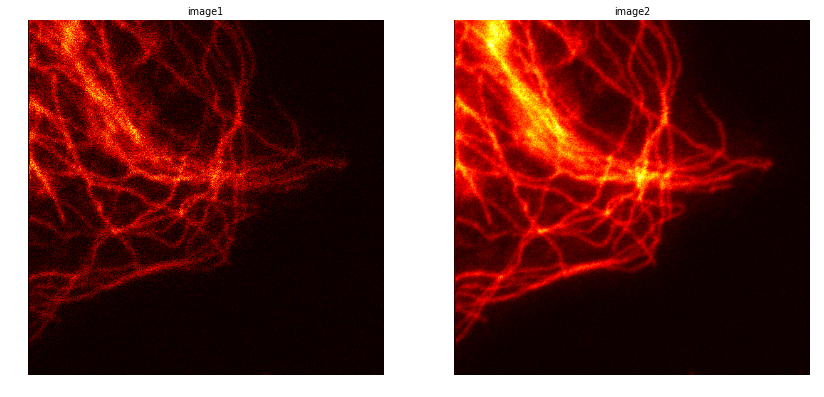

In [66]:
subset = (6,7,8,11,12,13,16,17,18)


result = ismrec.shift_and_sum(data, tranforms, detectors=subset)


implots.display_2d_images(data[0,12], result.astype(np.uint32))

## Realtime reassignment

It would of course be nice to be able to see the reassignment result in realtime during imaging. In order to do that the reassignment has to be run pixel-by-pixel and there's no possibility/time to perform the image alignment. Therefore one has to obtain the shifts beforehad. In theory they could be estimated from the detector specifications (pixel spacing), but in practice, many factors affect the actual shift between the images. Therefore one needs to find the shifts by calibration measurements. Let's see what that looks like.

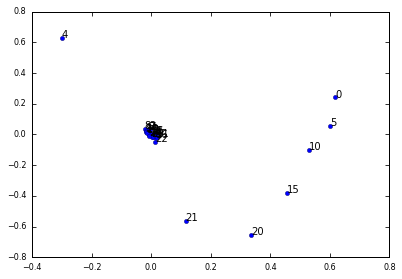

In [67]:
import supertomo.ui.plots.scatter as scatter


#shifts.plot(x='x', y='y', kind='scatter')

scatter.xy_scatter_plot_with_labels(x,y, range(len(x)))

Let's first discretize the shifts by converting from physical units to pixel space. That way one can find out how many pixels each pixel from a given image needs to be shifted in the result image.

In [68]:
import pandas
shifts = pandas.DataFrame({'x': x, 'y': y})

spacing = data[0,0].spacing

shifts['x_px'] = shifts['x']/spacing[0]
shifts['y_px'] = shifts['y']/spacing[1]

shifts.x_px = shifts.x_px.round()
shifts.y_px = shifts.y_px.round()
print spacing

print shifts

[0.02004008016032064, 0.02004008016032064]
           x         y  x_px  y_px
0   0.617900  0.240754  31.0  12.0
1   0.009489  0.012285   0.0   1.0
2  -0.007040  0.033200  -0.0   2.0
3  -0.011850  0.029264  -1.0   1.0
4  -0.300695  0.627745 -15.0  31.0
5   0.601184  0.055341  30.0   3.0
6   0.015283  0.000481   1.0   0.0
7  -0.005874  0.028795  -0.0   1.0
8  -0.022110  0.033920  -1.0   2.0
9  -0.018428  0.021065  -1.0   1.0
10  0.528797 -0.100724  26.0  -5.0
11  0.018189 -0.013669   1.0  -1.0
12  0.000000  0.000000   0.0   0.0
13 -0.015489  0.013366  -1.0   1.0
14 -0.016706  0.016974  -1.0   1.0
15  0.455899 -0.380845  23.0 -19.0
16  0.016174 -0.021162   1.0  -1.0
17  0.005065 -0.017094   0.0  -1.0
18 -0.006422 -0.001389  -0.0  -0.0
19 -0.013553  0.007219  -1.0   0.0
20  0.336474 -0.655505  17.0 -33.0
21  0.114849 -0.561696   6.0 -28.0
22  0.012186 -0.051952   1.0  -3.0
23  0.000615 -0.018652   0.0  -1.0
24 -0.006972 -0.007100  -0.0  -0.0


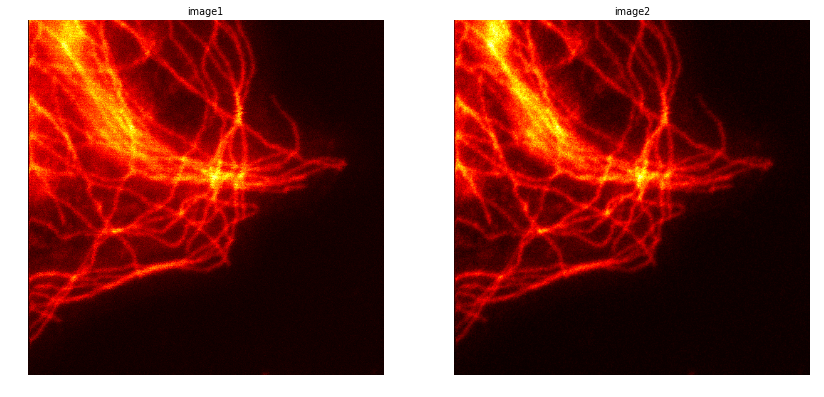

In [69]:
from supertomo.data.containers.image import Image
dims = data[0,0].shape

result_sum = Image(np.zeros(dims, dtype=np.float64), spacing)

for image in range(data.ndetectors):
    result_sum += data[0, image]
    
implots.display_2d_images(result_sum.astype(np.int32), result.astype(np.uint32))

In [70]:
from supertomo.data.containers.fourier_correlation_data import FourierCorrelationDataCollection
import supertomo.analysis.resolution.analysis as frc_analysis
import supertomo.data.iterators.fourier_ring_iterators as iterators

import supertomo.analysis.resolution.fourier_ring_correlation as frc


def measure_single_image_resolution(image, args):
    data = FourierCorrelationDataCollection()

    image1, image2 = imops.checkerboard_split(image)
    iterator = iterators.FourierRingIterator(image1.shape, args.d_bin)

    frc_task = frc.FRC(image1, image2, iterator)
    data[0] = frc_task.execute()

    analyzer = frc_analysis.FourierCorrelationAnalysis(data, image1.spacing[0], args)
    return analyzer.execute()[0]

In [71]:
import supertomo.ui.frc_options as options

data_dir = os.path.join(os.getcwd(), "none")
args_list = [data_dir, '--bin-delta=8', '--frc-curve-fit-degree=4', 
            '--resolution-threshold-criterion=snr', '--resolution-snr-value={}'.format(0.25), '--use-splines']

args = options.get_frc_script_options(args_list)

print args

Namespace(d_angle=20, d_bin=8, d_extract_angle=5.0, debug=False, directory='/Users/sami/Programming/GIT/supertomo2/notebooks/none', frc_curve_fit_degree=4, hanning=False, hollow_iterator=False, min_filter=False, pathout=None, resol_square=False, resolution_point_sigma=0.01, resolution_snr_value=0.25, resolution_threshold_criterion='snr', resolution_threshold_curve_fit_degree=3, resolution_threshold_value=0.5, use_splines=True)


In [72]:
results = FourierCorrelationDataCollection()

results[0] = measure_single_image_resolution(result_sum, args)
results[1] = measure_single_image_resolution(result, args)



Fit starts at 0.512000024319
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 10
         Function evaluations: 20
Fit starts at 0.575999975204
Optimization terminated successfully.
         Current function value: 0.000041
         Iterations: 10
         Function evaluations: 20


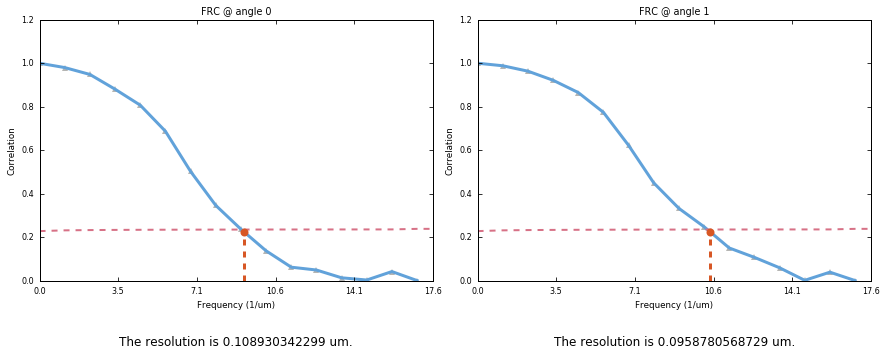

In [73]:
import supertomo.ui.plots.frc as frcplots


plotter = frcplots.FourierDataPlotter(results)
plotter.plot_all()

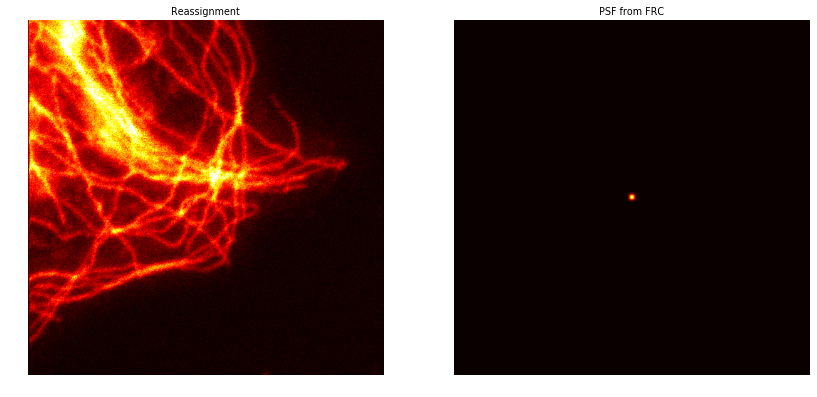

In [74]:
import supertomo.psf.psfgen as psfgen

fwhm = [results[1].resolution['resolution'],] * 2

psf_generator = psfgen.PsfFromFwhm(fwhm)

psf = psf_generator.xy()

implots.display_2d_images(imops.enhance_contrast(result, percent_saturated=0.3), 
                         psf,
                         image1_title="Reassignment",
                         image2_title="PSF from FRC"
                         
                    )

The zoom is  (1.559375, 1.559375)


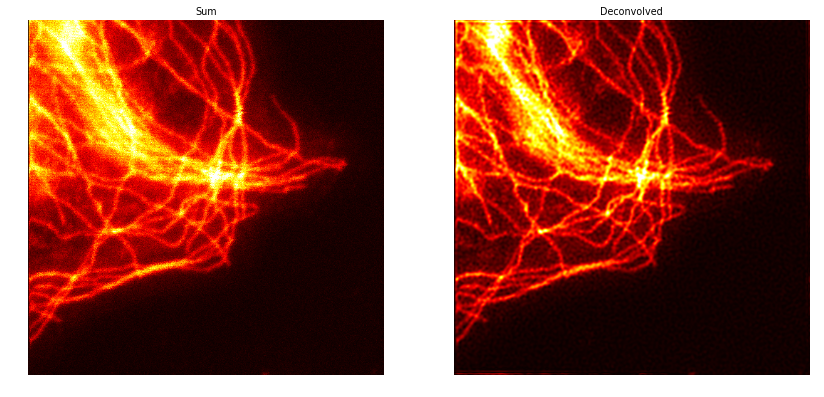

In [77]:
from supertomo.processing.deconvolution import wiener

deconvolution_result = wiener.wiener_deconvolution(result, psf, snr=50)

implots.display_2d_images(imops.enhance_contrast(result_sum, percent_saturated=0.3), 
                         imops.enhance_contrast(deconvolution_result, percent_saturated=0.3),
                         image1_title="Sum",
                         image2_title="Deconvolved"
                         
                    )

Fit starts at 0.768000006676
Optimization terminated successfully.
         Current function value: 0.000032
         Iterations: 10
         Function evaluations: 20


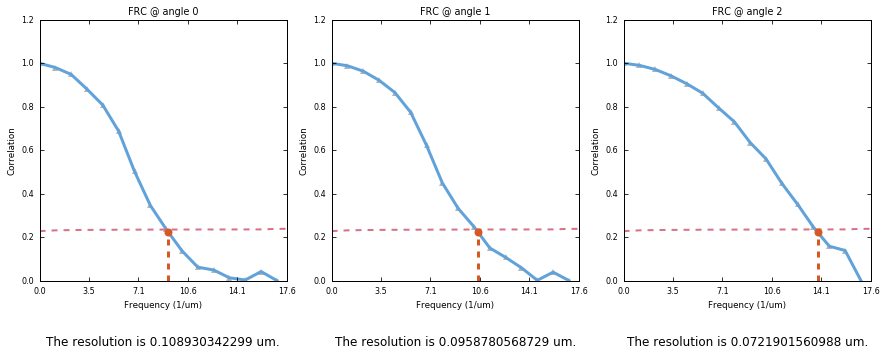

In [76]:
results[2] = measure_single_image_resolution(deconvolution_result, args)

plotter = frcplots.FourierDataPlotter(results)
plotter.plot_all()

The zoom is  (1.559375, 1.559375)


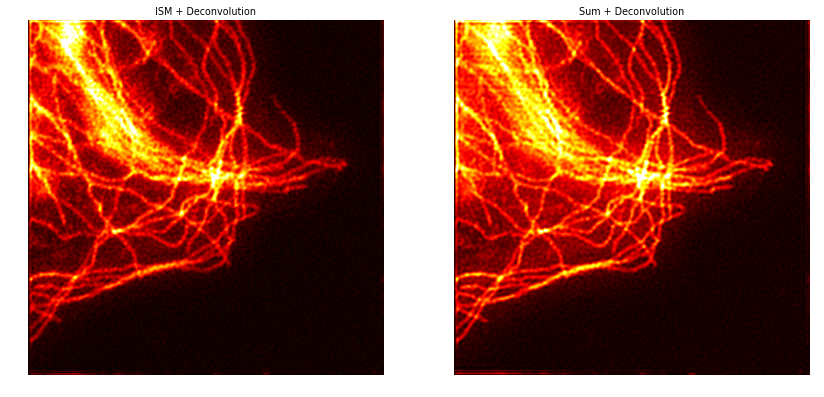

In [81]:
import supertomo.psf.psfgen as psfgen

fwhm = [results[0].resolution['resolution'],] * 2

psf_generator = psfgen.PsfFromFwhm(fwhm)

psf = psf_generator.xy()

sum_deconvolution_result = wiener.wiener_deconvolution(result_sum, psf, snr=50)



implots.display_2d_images(imops.enhance_contrast(deconvolution_result, percent_saturated=0.3), 
                         imops.enhance_contrast(sum_deconvolution_result, percent_saturated=0.3),
                         image1_title="ISM + Deconvolution",
                         image2_title="Sum + Deconvolution"
                         
                    )

Fit starts at 0.768000006676
Optimization terminated successfully.
         Current function value: 0.000022
         Iterations: 10
         Function evaluations: 20


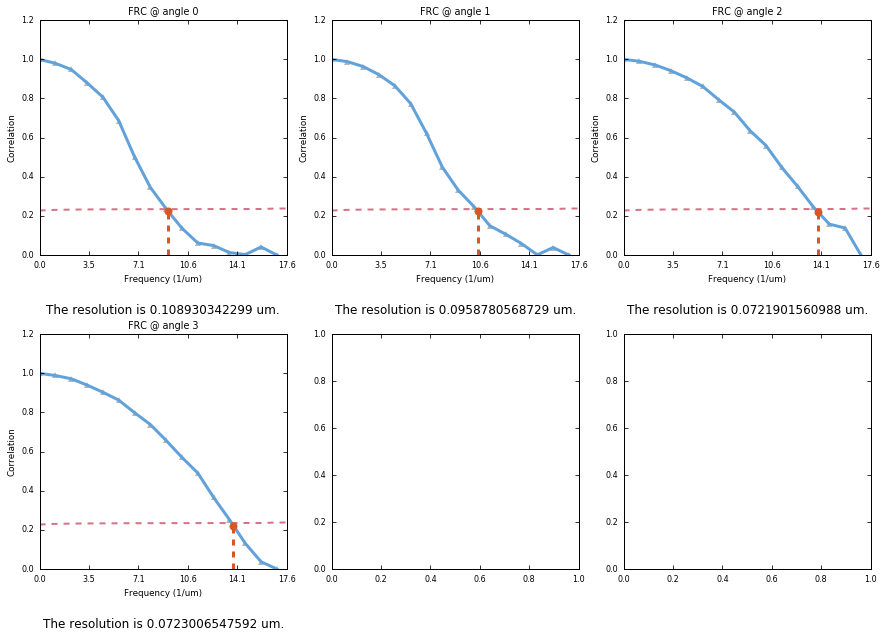

In [82]:
results[3] = measure_single_image_resolution(sum_deconvolution_result, args)

plotter = frcplots.FourierDataPlotter(results)
plotter.plot_all()